# RNA velocity with scvelo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scvelo as scv

In [2]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

In [ ]:
adata.X = adata.layers["spliced"] + adata.layers["unspliced"]
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

In [17]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [18]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [19]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/160 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


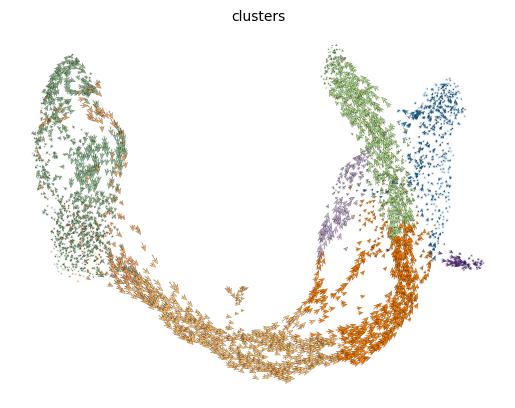

In [20]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, color='clusters')

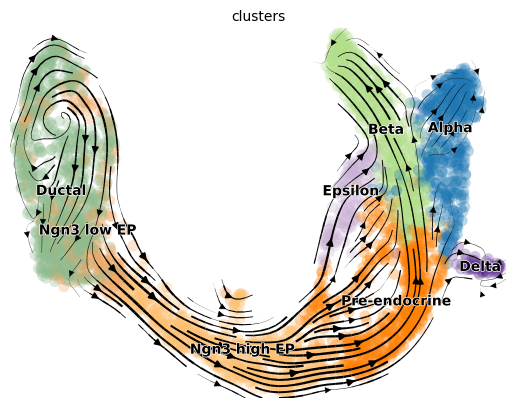

In [21]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='clusters')

# Phase portraits and gene-wise velocity results

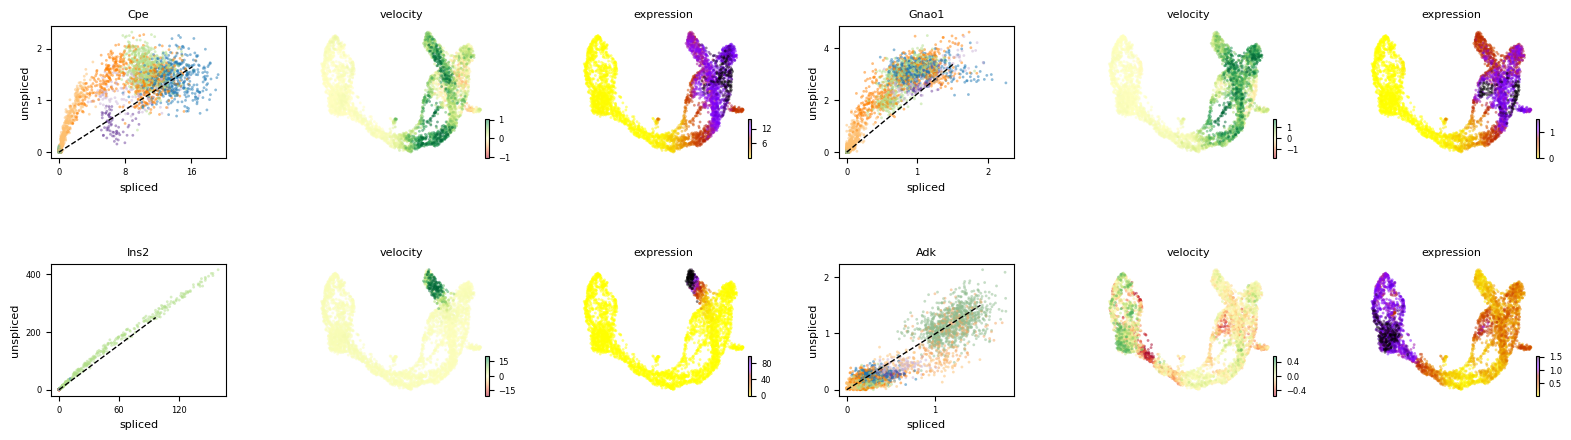

In [22]:
scv.pl.velocity(adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

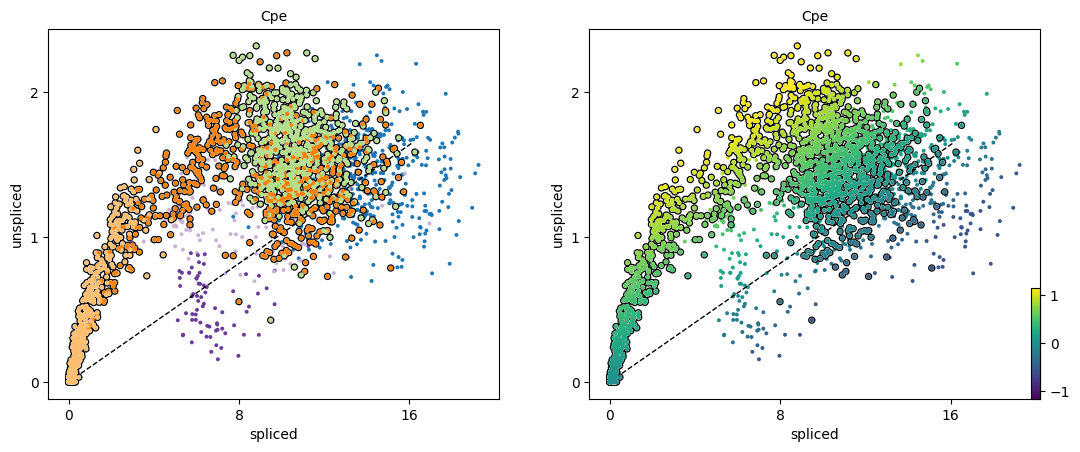

In [23]:
scv.pl.scatter(adata, 'Cpe', color=['clusters', 'velocity'],
               add_outline='Ngn3 high EP, Pre-endocrine, Beta')

In [24]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)

df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine     Beta    Alpha     Delta  \
0  Notch2       Ptpn3        Pde1c          Sdk1     Pax6  Zcchc16     Ptprt   
1    Sox5      Slc9a9         Pclo         Abcc8    Unc5c   Prune2     Zdbf2   
2   Krt19       Kcnq1        Grik2          Gnas     Nnat    Nell1    Spock3   
3    Ano6      Dcbld1        Ttyh2        Ptprn2     Scg3     Aff2  Slc16a12   
4   Rbms3   Trp53cor1       Setbp1         Asic2  Tmem108    Chrm3   Fam155a   

   Epsilon  
0     Ica1  
1   Ctnna2  
2   Sorcs1  
3     A1cf  
4  Zcchc16

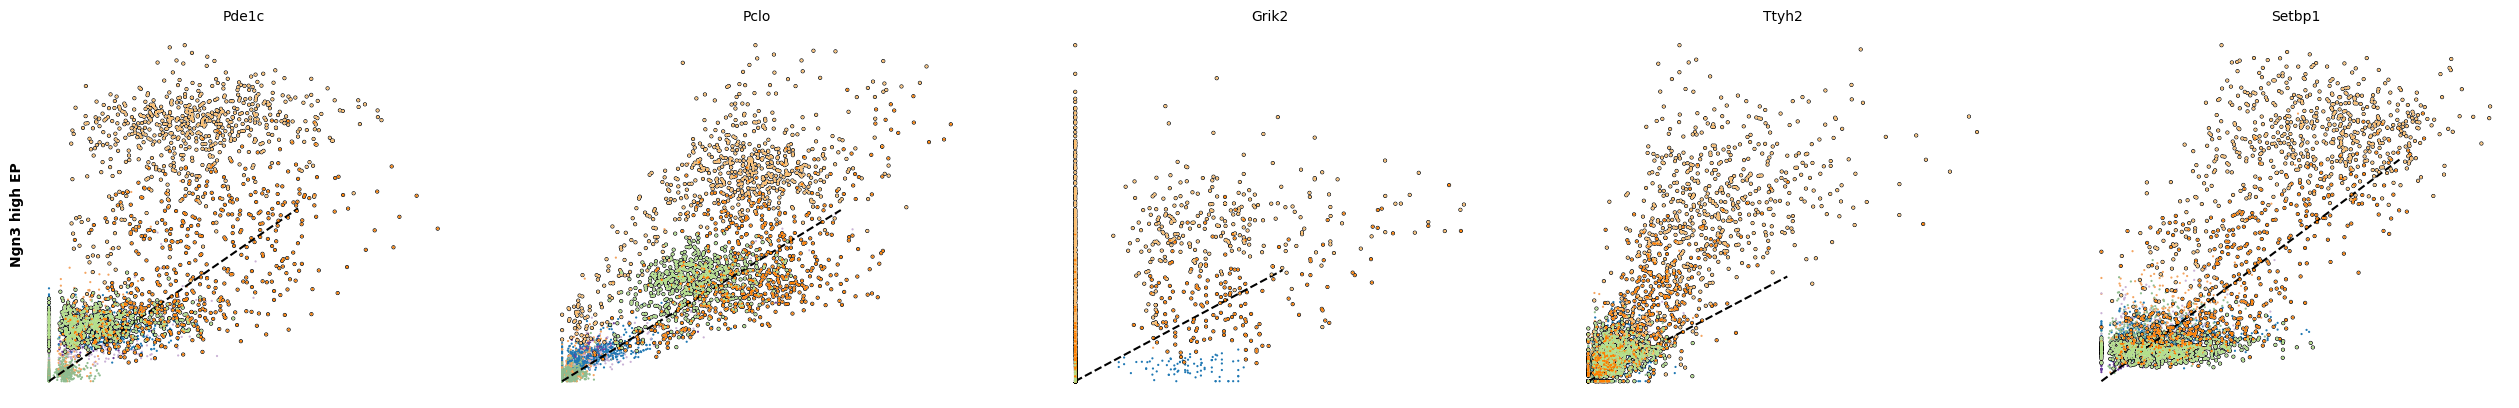

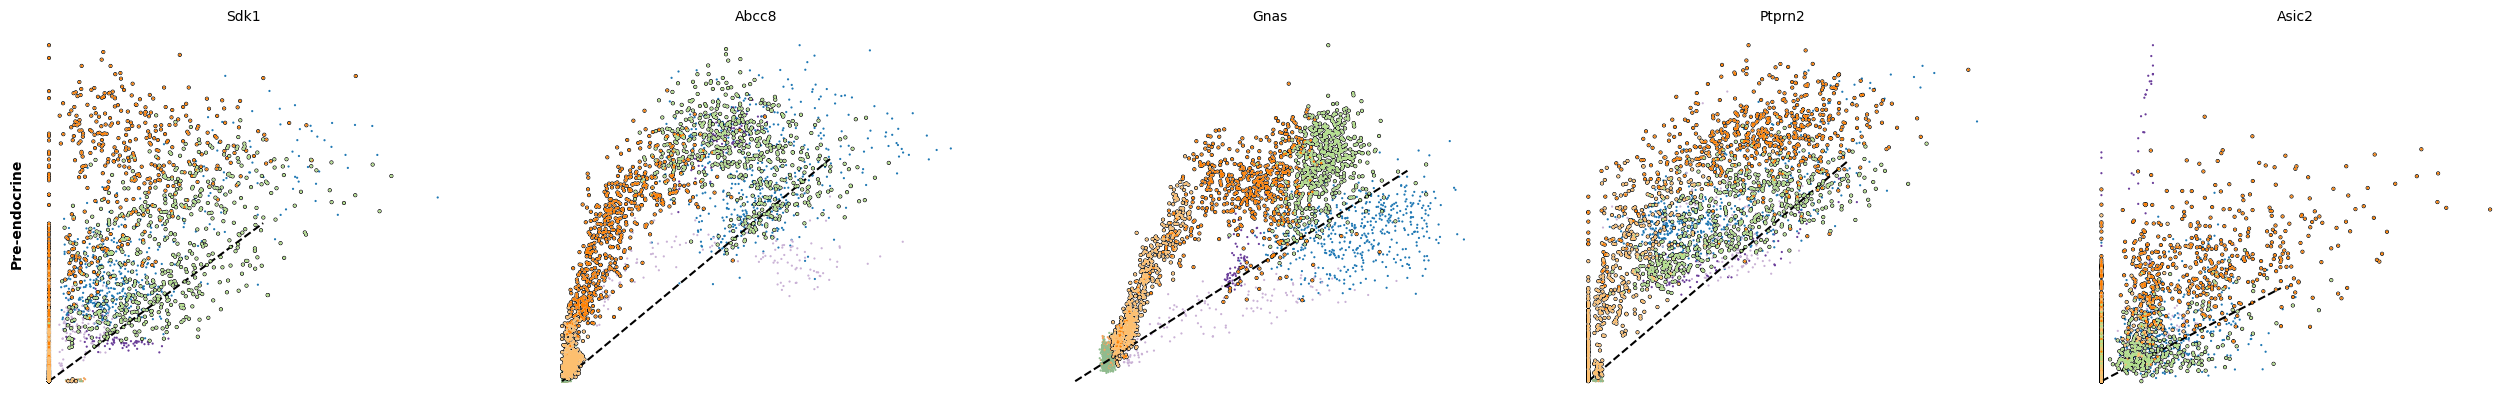

In [25]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='Ngn3 high EP, Pre-endocrine, Beta')

scv.pl.scatter(adata, df['Ngn3 high EP'][:5], ylabel='Ngn3 high EP', **kwargs)
scv.pl.scatter(adata, df['Pre-endocrine'][:5], ylabel='Pre-endocrine', **kwargs)

The genes Ptprs, Pclo, Pam, Abcc8, Gnas, for instance, support the directionality from Ngn3 high EP (yellow) to Pre-endocrine (orange) to Beta (green).

## Dynamical modeling of RNA velocity

Since RNA velocity yields insights into the directionality of gene expression change, we can use the approach to infer a trajectory. One way this is acheives is by recovering estimates of the full transcriptional dynamics (i.e., the transcription rate, the splicing rate, and the degradation rate) instead of using the steady-state asusmption and linear fits. This is particularly useful when you have a dataset without a cluster of cells representing the "steady-state". 

Dynamical modeling of RNA velocity is possible with scvelo and allows for:
- Estimation of a latent time
- Identification of possible driver genes

In [26]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/160 cores)


  0%|          | 0/1044 [00:00<?, ?gene/s]

    finished (0:06:39) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [27]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/160 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


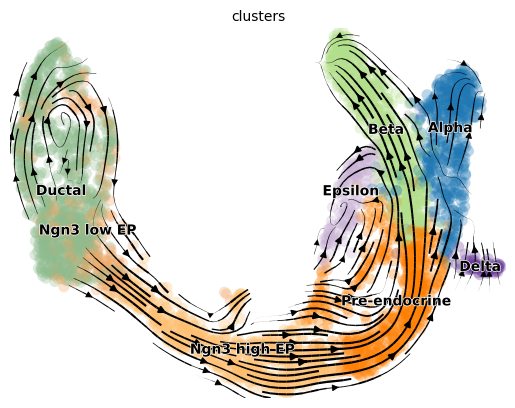

In [28]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

**With the dynamical model**, The rates of RNA transcription, splicing and degradation are estimated without the need of any experimental data.

They can be useful to better understand the cell identity and phenotypic heterogeneity.

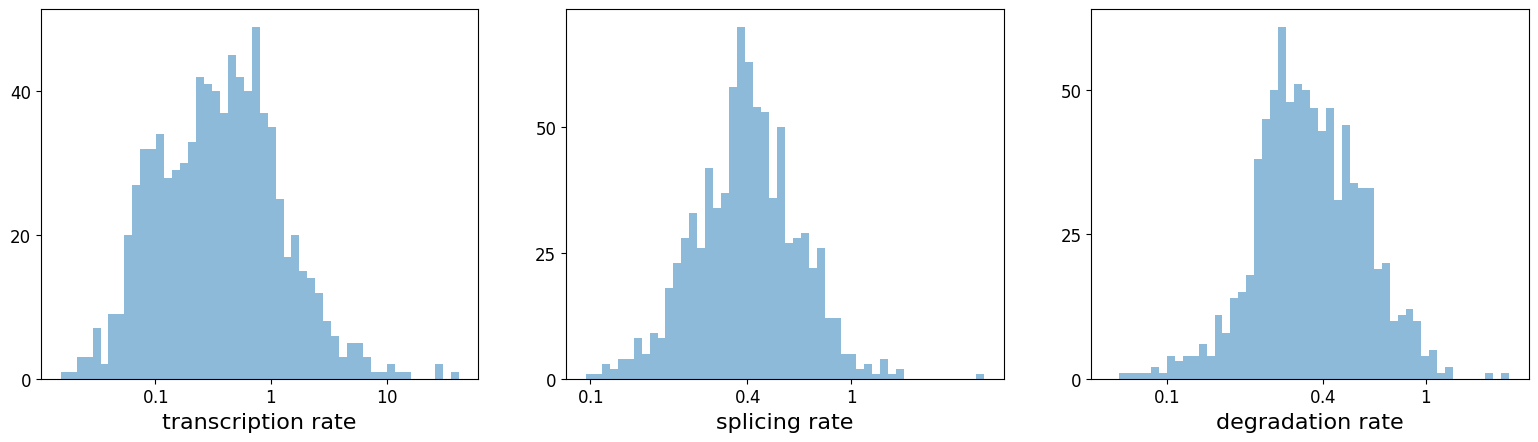

fit_alpha   fit_beta  fit_gamma     fit_t_  fit_scaling  fit_std_u  \
index                                                                         
Sntg1     0.010688   0.003801   0.070298  26.614919    48.409039   1.015340   
Sbspon    0.466790   2.485521   0.407607   3.988951     0.145663   0.058015   
Mcm3      3.759589  52.011484   0.885513   1.945249     0.011923   0.015849   
Fam135a   0.185720   0.124718   0.218989  10.854791     1.090526   0.353996   
Adgrb3    0.034546   0.007763   0.222066   8.947714   120.303430   2.122017   

         fit_std_s  fit_likelihood  fit_u0  fit_s0  fit_pval_steady  \
index                                                                 
Sntg1     0.024470        0.382195     0.0     0.0         0.034819   
Sbspon    0.188189        0.267242     0.0     0.0         0.206473   
Mcm3      0.686825        0.118566     0.0     0.0         0.483623   
Fam135a   0.153378        0.293041     0.0     0.0         0.397257   
Adgrb3    0.030074        0.295653     0.0     0.0         0.063172   

         fit_steady_u  fit_steady_s  fit_variance  fit_alignment_scaling  \
index                                                                      
Sntg1        2.402895      0.072442      0.238926               6.656648   
Sbspon       0.150839      0.503312      0.690054               1.242929   
Mcm3         0.060455      2.054615      1.426064               0.765975   
Fam135a      1.331401      0.395752      0.611777               3.308631   
Adgrb3       4.564255      0.093443      0.525843               1.825699   

           fit_r2  
index              
Sntg1    0.467566  
Sbspon   0.630782  
Mcm3     0.275293  
Fam135a  0.363101  
Adgrb3   0.399879

In [29]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


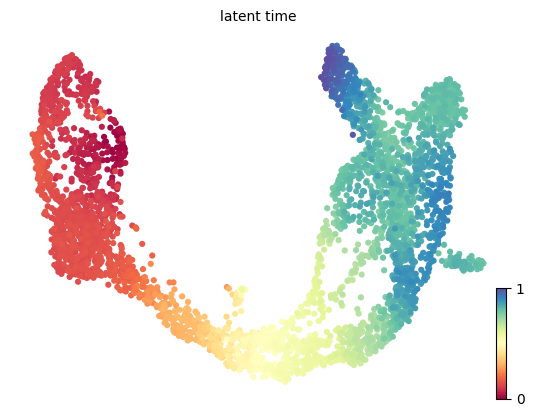

In [38]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map=plt.cm.Spectral, size=80)

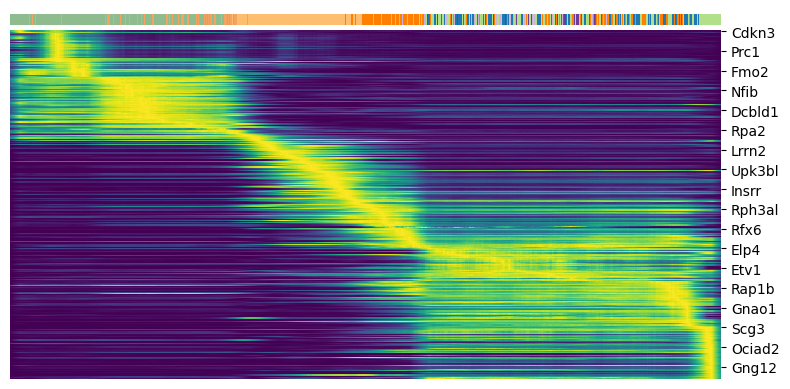

In [31]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

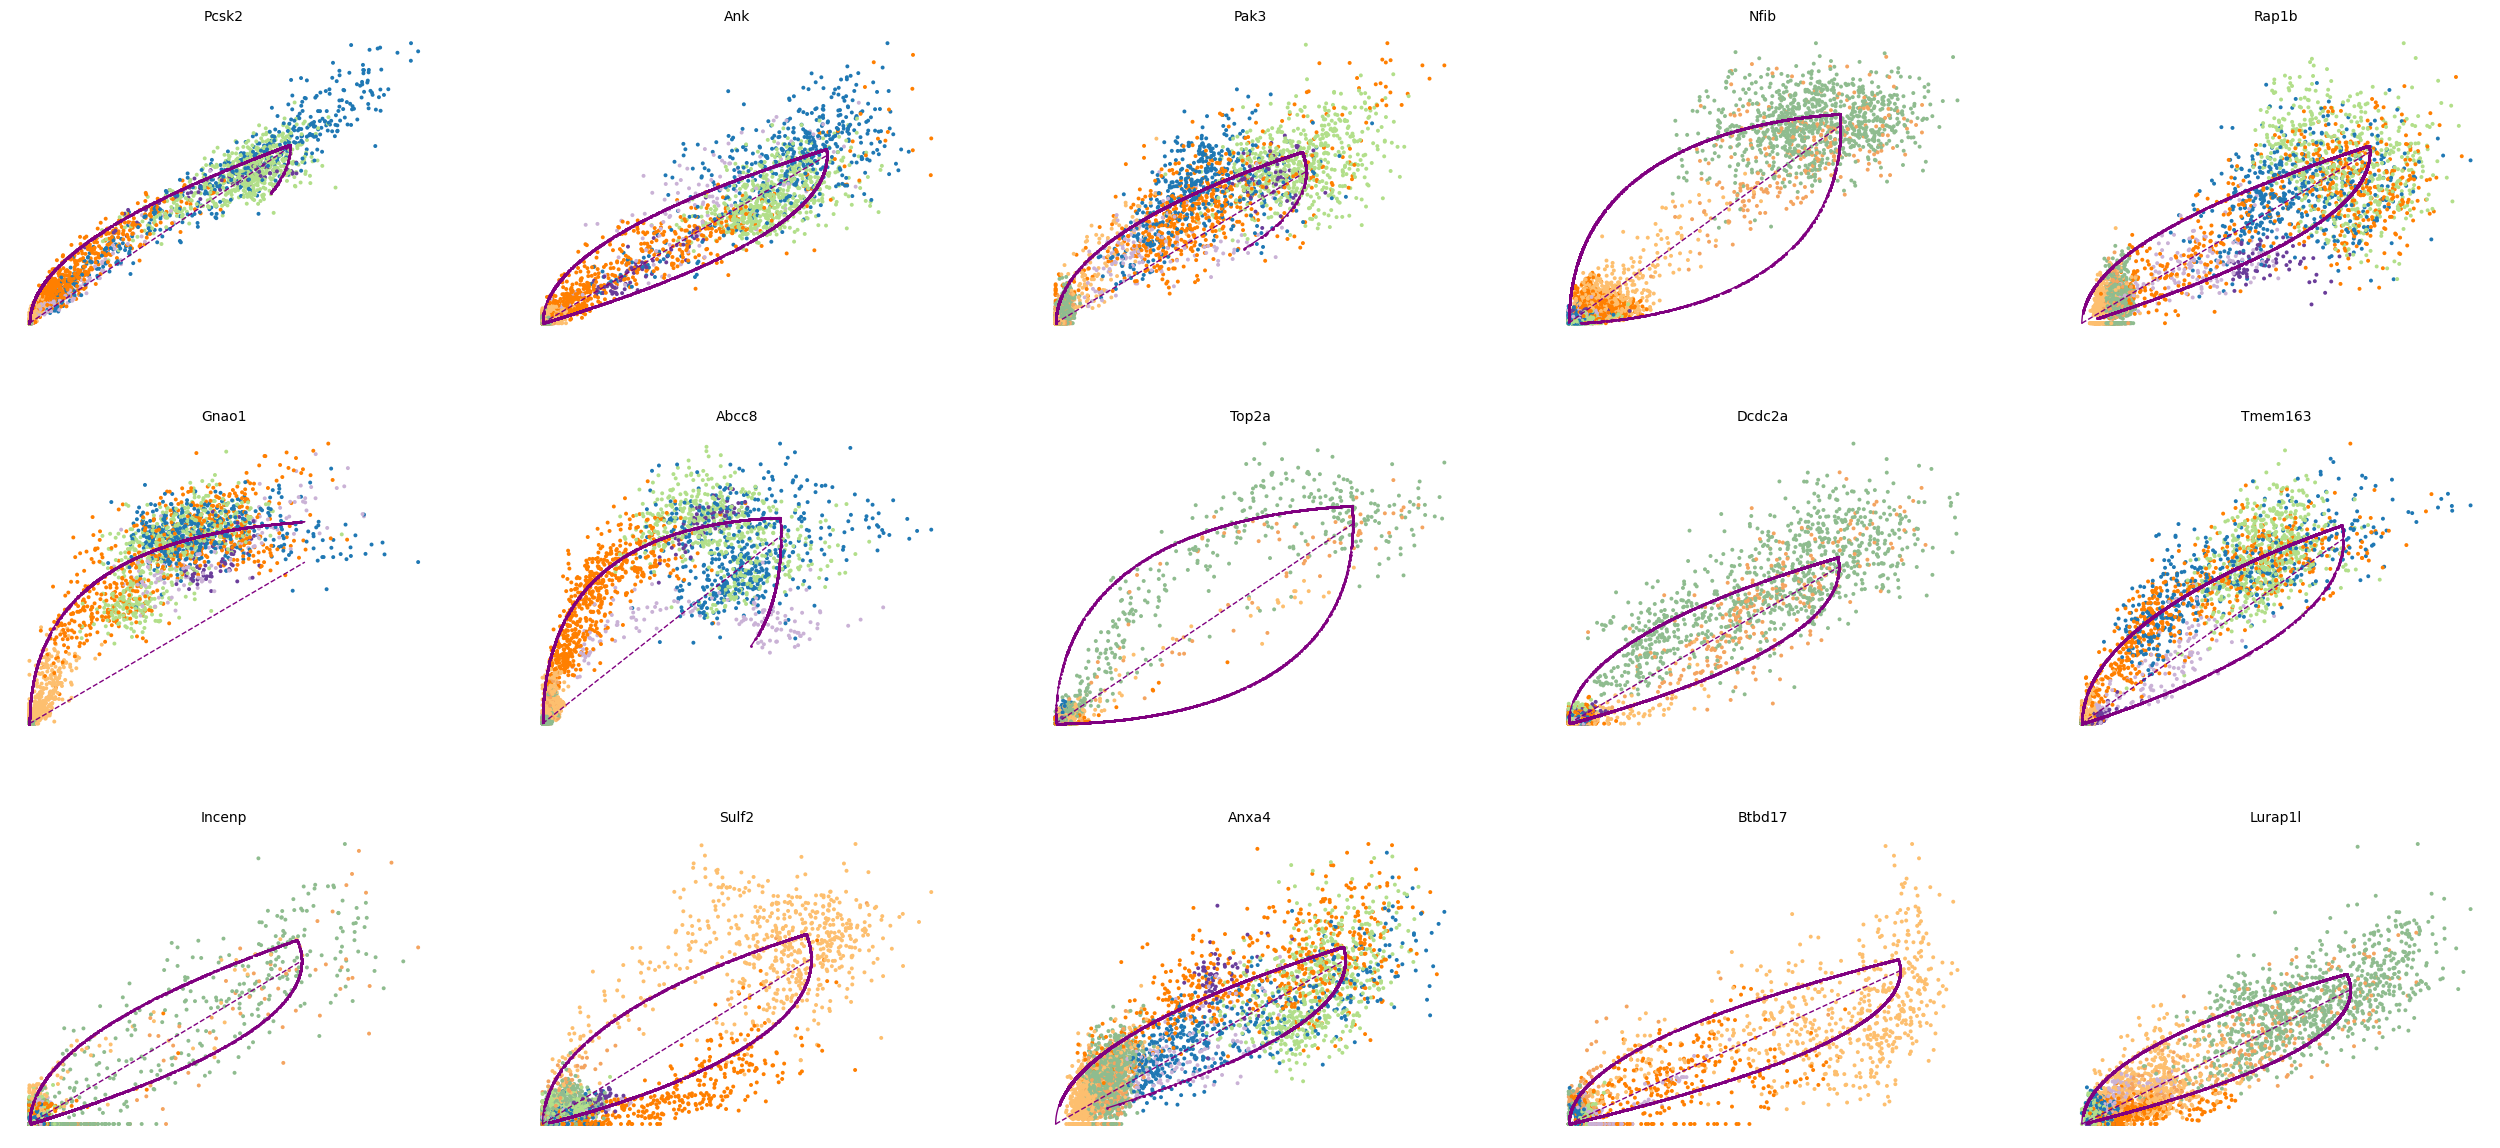

In [32]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

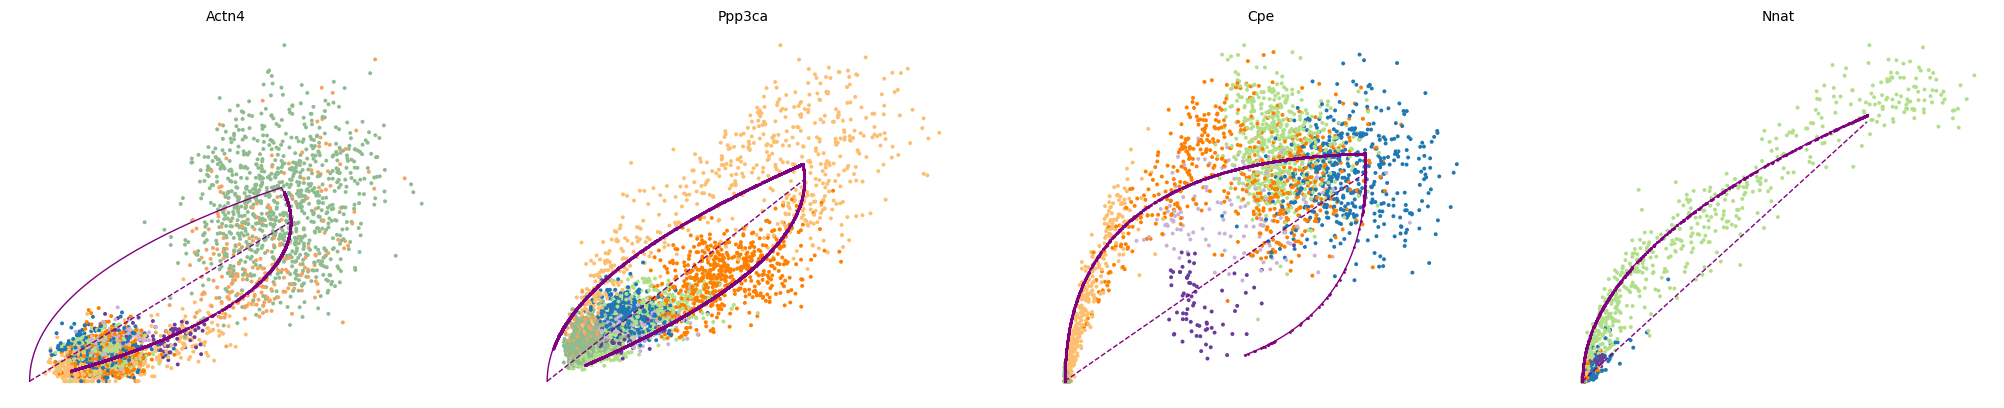

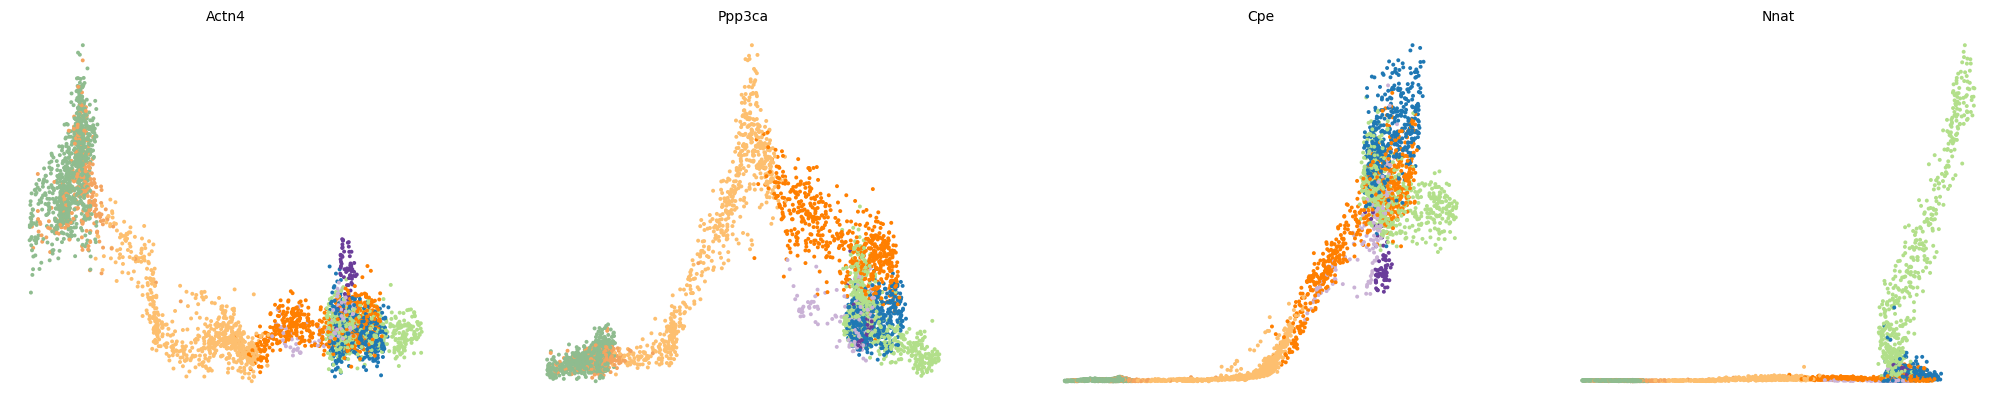

In [33]:
var_names = ['Actn4', 'Ppp3ca', 'Cpe', 'Nnat']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)

In [34]:
scv.tl.rank_dynamical_genes(adata, groupby='clusters')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:03) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine    Beta  Alpha  Delta  \
0     Nfib       Lockd       Rbfox3         Pcsk2   Pcsk2  Gnao1  Pcsk2   
1    Top2a      Dcdc2a       Btbd17         Abcc8     Ank    Cpe  Abcc8   
2   Incenp         Adk       Tspan5         Rap1b   Abcc8   Pak3   Pak3   
3  Wfdc15b       Bicc1     Rap1gap2       Tmem163  Tspan7  Rap1b  Rap1b   
4     Cdk1     Wfdc15b        Sulf2           Ank  Cryba2   Pim2  Meis2   

    Epsilon  
0      Pak3  
1      Tox3  
2  Rap1gap2  
3    Rnf130  
4     Meis2

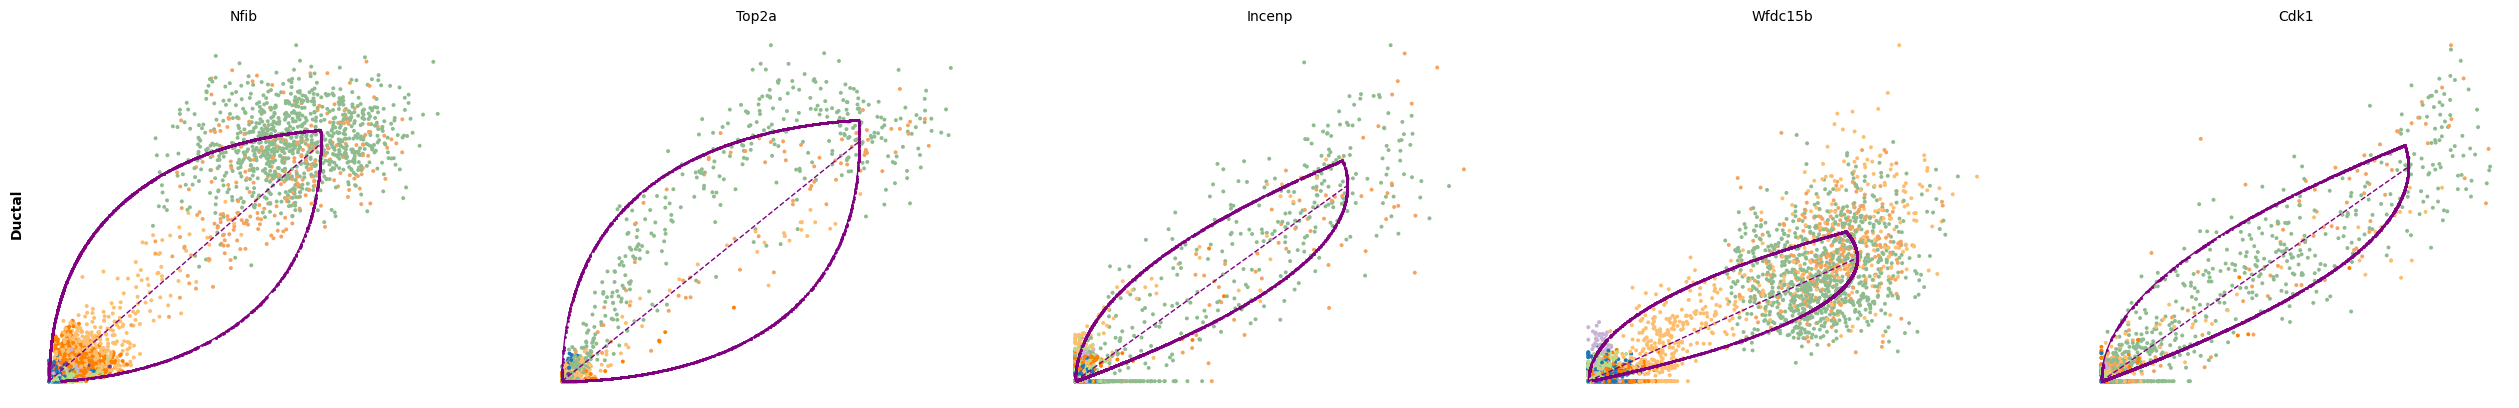

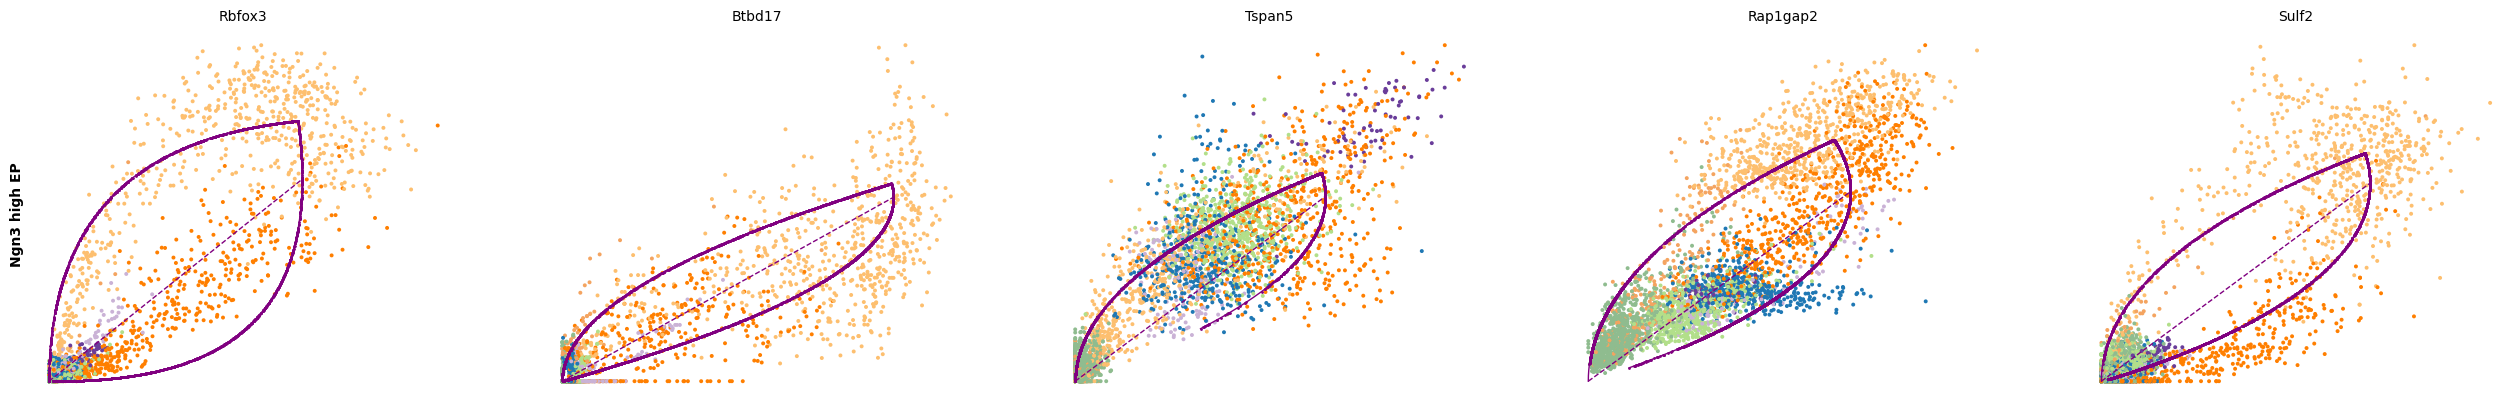

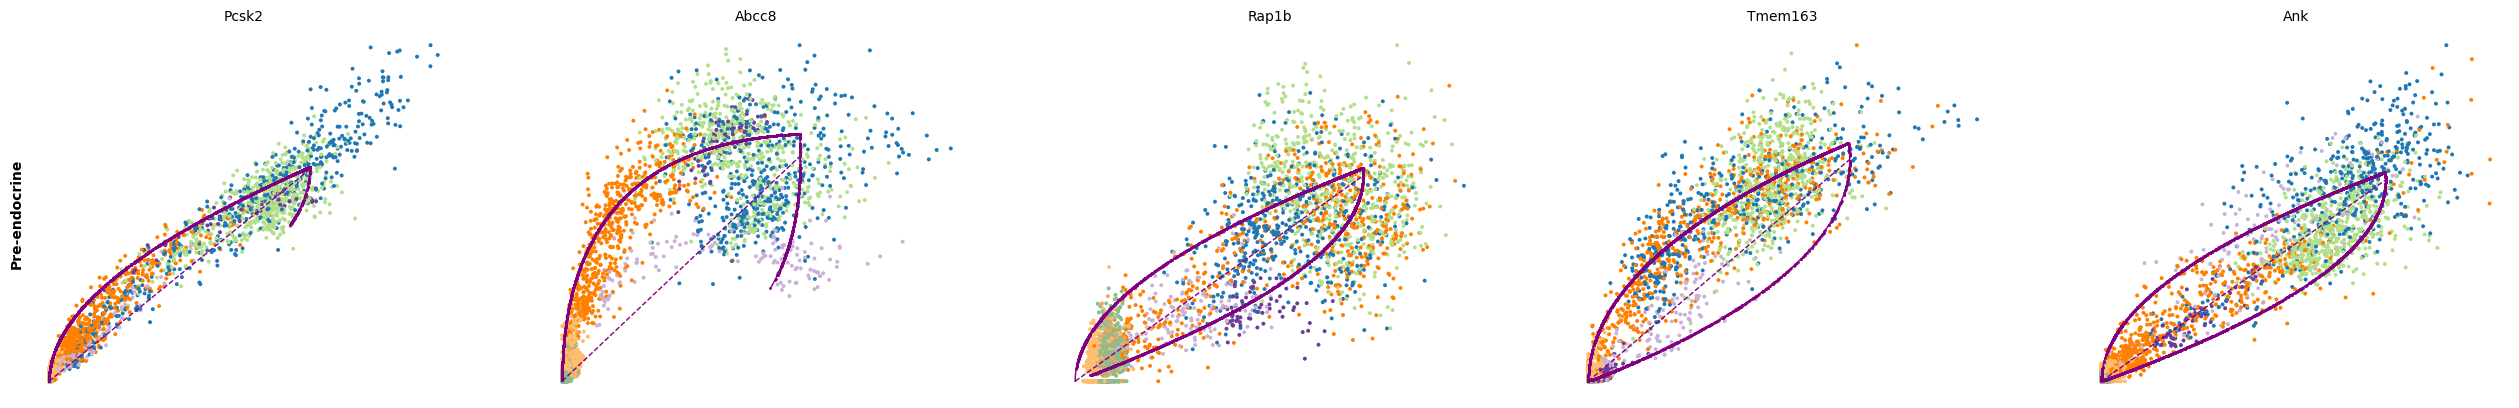

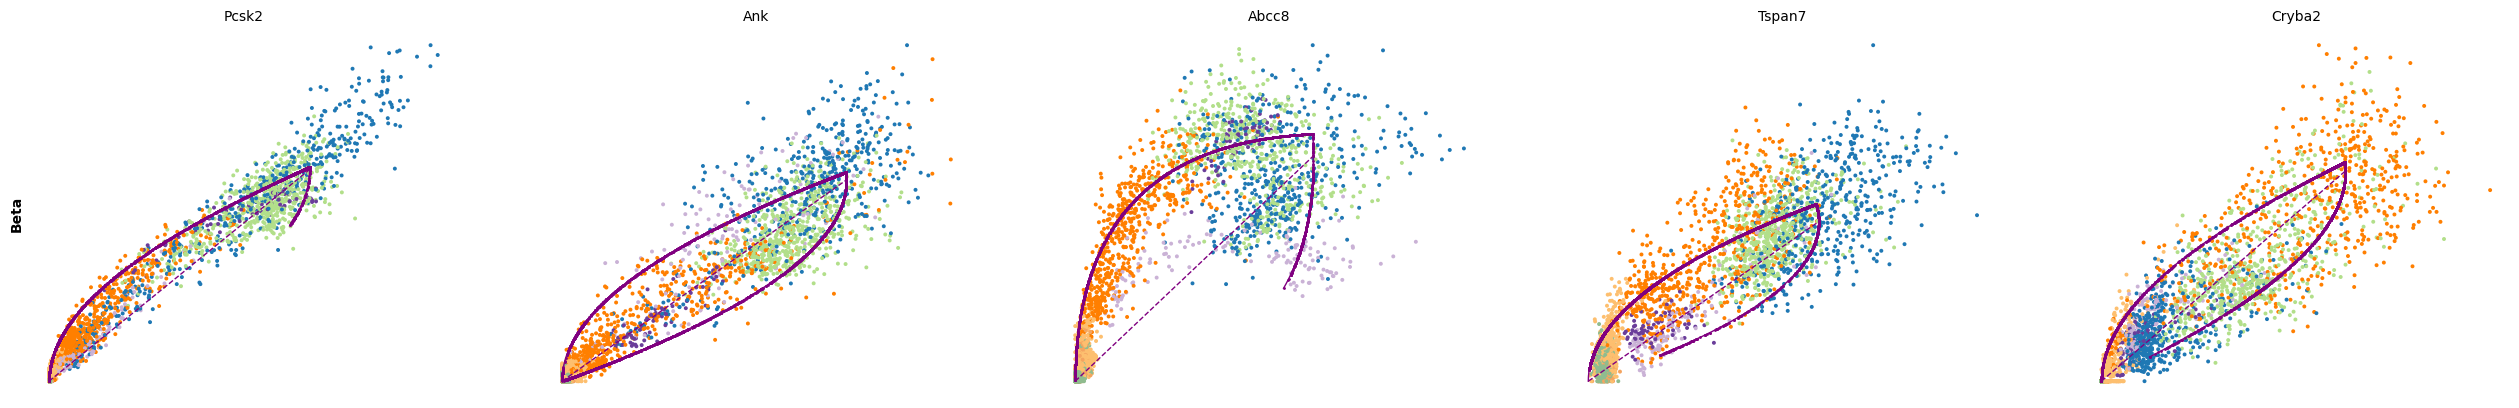

In [35]:
for cluster in ['Ductal', 'Ngn3 high EP', 'Pre-endocrine', 'Beta']:
    scv.pl.scatter(adata, df[cluster][:5], ylabel=cluster, frameon=False)

## Velocities in cycling progenitors

The cell cycle detected by RNA velocity, and it is biologically affirmed by cell cycle scores (standardized scores of mean expression levels of phase marker genes).

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


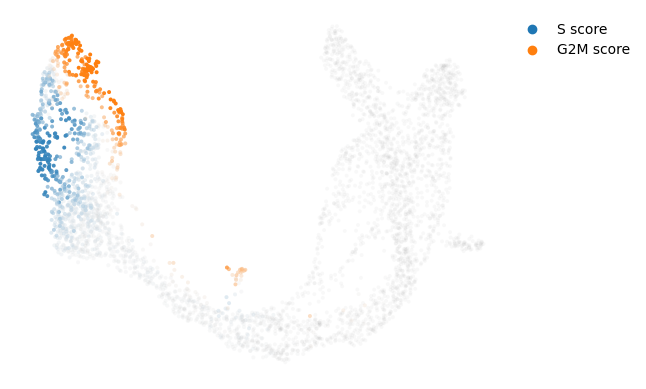

In [36]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

For the cycling Ductal cells, we may screen through S and G2M phase markers. The previous module also computed a spearmans correlation score, which we can use to rank/sort the phase marker genes to then display their phase portraits.

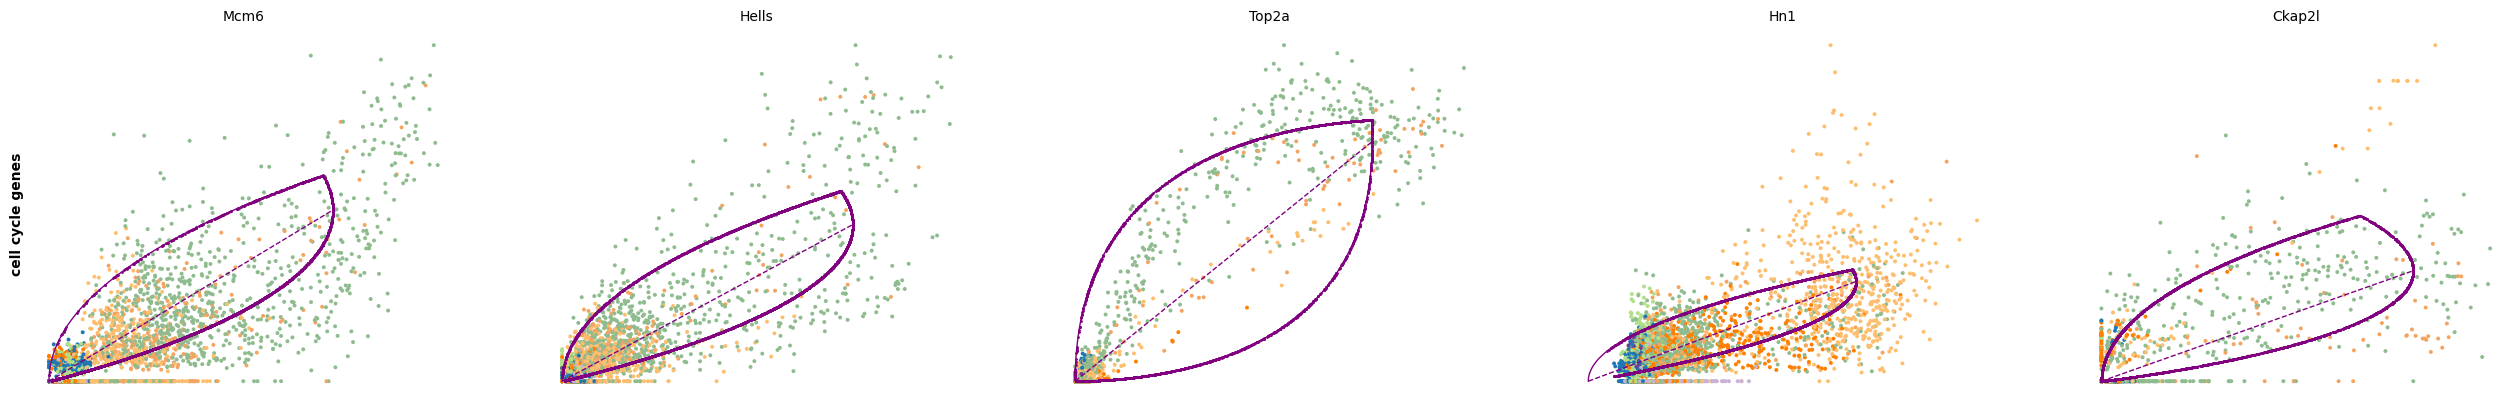

In [37]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)

Particularly Hells and Top2a are well-suited to explain the vector field in the cycling progenitors. Top2a gets assigned a high velocity shortly before it actually peaks in the G2M phase. There, the negative velocity then perfectly matches the immediately following down-regulation.

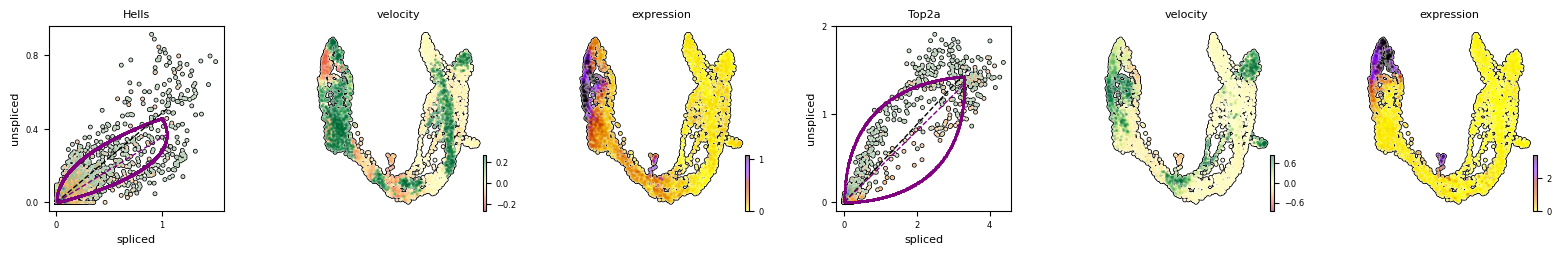

In [28]:
scv.pl.velocity(adata, ['Hells',  'Top2a'], ncols=2)

The cell cycle is an interesting case for RNA velocity estimation, as pseudotime methods along often fail as estimations of cyclical processes. Moreover, RNA velocity corresponds roughly to cell cycle speed, which is both experimentally verifiable. The cell cycle also unfolds on a timescale of less than 24 hours, which is well suited for studying cell dynamics using RNA lifecycle kinetics, such as with RNA velocity. 